In [1]:
%load_ext Cython
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

##How to accelerate a pandas.DataFrame.apply call

###Random dataframe

In [3]:
# x is here only so that the apply returns a series with dtype object
df = pd.DataFrame({'a': np.random.randn(1000),
                   'b': np.random.randn(1000),
                   'N': np.random.randint(100, 1000, (1000)),
                   'x': 'x'})
print df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 4 columns):
N    1000 non-null int64
a    1000 non-null float64
b    1000 non-null float64
x    1000 non-null object
dtypes: float64(2), int64(1), object(1)
memory usage: 39.1+ KB
None


,N,a,b,x
0,807,-1.185118,0.634840,x
1,381,1.198917,-0.094241,x
2,740,-1.378058,0.188600,x
3,782,-0.002901,-0.182898,x
4,948,-0.804665,-0.662428,x


###Python vs Cython

In [4]:
def f(x):
    return x * (x - 1)

def integrate_f(a, b, N):
    s = 0
    dx = (b - a) / N
    for i in xrange(N):
        s += f(a + i * dx)
    return s * dx

In [5]:
%%cython -a

cimport cython

cdef double f_C(double x):
    return x * (x - 1)

@cython.cdivision(True)
cpdef double integrate_f_C(double a, double b, int N):
    cdef int i
    cdef double s, dx
    s = 0
    dx = (b - a) / N
    for i in range(N):
        s += f_C(a + i * dx)
    return s * dx

In [6]:
%%cython -a

cimport cython
cimport numpy as np
import numpy as np

cdef double f_C(double x):
    return x * (x - 1)

@cython.cdivision(True)
cpdef double integrate_f_C(double a, double b, int N):
    cdef int i
    cdef double s, dx
    s = 0
    dx = (b - a) / N
    for i in range(N):
        s += f_C(a + i * dx)
    return s * dx

@cython.boundscheck(False)
cpdef double[:] f_allinone(double[:] col_a, double[:] col_b, long[:] col_N):
    #assert (col_a.dtype==np.float and col_b.dtype==np.float and col_N.dtype==np.int)
    assert (col_a.shape[0]==col_b.shape[0]==col_N.shape[0])
    cdef double[:] res = np.empty(col_N.shape[0], dtype=np.float64)
    cdef int a = col_a.shape[0]
    cdef int i
    for i in range(a):
        res[i] = integrate_f_C(col_a[i], col_b[i], col_N[i])
    return res


In [7]:
rr1 = df.apply(lambda x: integrate_f(x['a'], x['b'], x['N']), axis=1)
rr2 = df.apply(lambda x: integrate_f_C(x['a'], x['b'], x['N']), axis=1)
rr3 = f_allinone(df['a'].values, df['b'].values, df['N'].values)

print (rr1==rr2).all()
print (rr1==rr3).all()

True
True


In [8]:
%timeit df.apply(lambda x: integrate_f(x['a'], x['b'], x['N']), axis=1)
%timeit df.apply(lambda x: integrate_f_C(x['a'], x['b'], x['N']), axis=1)
%timeit f_allinone(df['a'].values, df['b'].values, df['N'].values)

10 loops, best of 3: 108 ms per loop
100 loops, best of 3: 13.6 ms per loop
1000 loops, best of 3: 521 µs per loop


In [9]:
%prun -l 4 df.apply(lambda x: integrate_f_C(x['a'], x['b'], x['N']), axis=1)

##How to accelerate a recurring function over a pandas.DataFrame column

###Brownian Motion

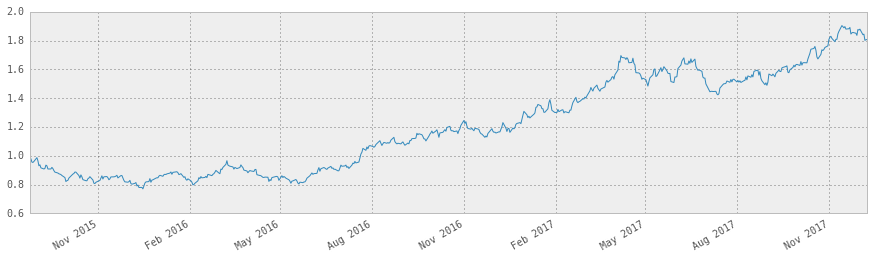

In [10]:
np.random.seed(123756)

rate = 0.02
vol = 0.25
Nb_bd = 600
dt = 1.0/260
returns = (rate-vol**2/2)*dt+vol*np.sqrt(dt)*np.random.normal(size=Nb_bd)
track = (1.0+returns).cumprod()

dates = pd.date_range(start=pd.datetime.today(), periods=Nb_bd, freq='B')
df = pd.DataFrame(data=track, index=dates, columns=['track'])

df['date'] = df.index
df['day_diff'] = (df['date']-df['date'].shift(1)).apply(lambda x : x/np.timedelta64(1,'D'))
df.drop('date', axis=1, inplace=True)

df['track'].plot(figsize=(15, 4));

###Python vs Cython

In [11]:
def floor(a):
    return a if a>0 else 0

def new_col(col, daydiff, harddiv, k):
    n = col.shape[0]
    newcol = np.empty(n)
    for i in range(k+1):
        newcol[i] = col[i]
    for i in range(k+1, n):
        newcol[i] = floor(newcol[i-1] * col[i]/col[i-1] - harddiv * daydiff[i] / 365.0)
    return newcol

In [19]:
%%cython -a
cimport cython
cimport numpy as np
import numpy as np

cdef inline double floor(double a): return a if a>0 else 0

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
cpdef new_col_C(double[:] col,
              double[:] daydiff,
              double harddiv,
              int k):
    cdef int n = col.shape[0]
    cdef double[:] newcol = np.empty(n, dtype=np.float64)
    cdef int i
    for i in range(k+1):
        newcol[i] = col[i]
    for i in range(k+1, n):
        newcol[i] = floor(newcol[i-1] * col[i]/col[i-1] - harddiv * daydiff[i] / 365.0)
    return newcol


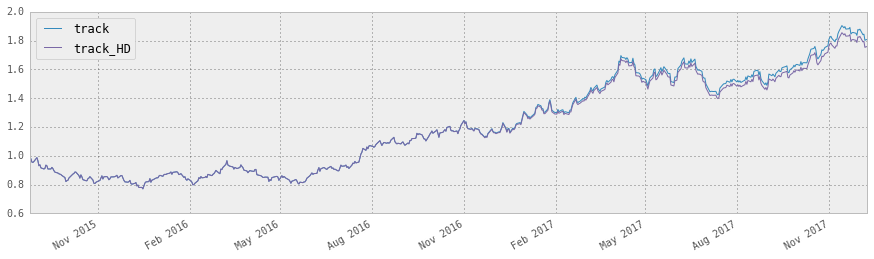

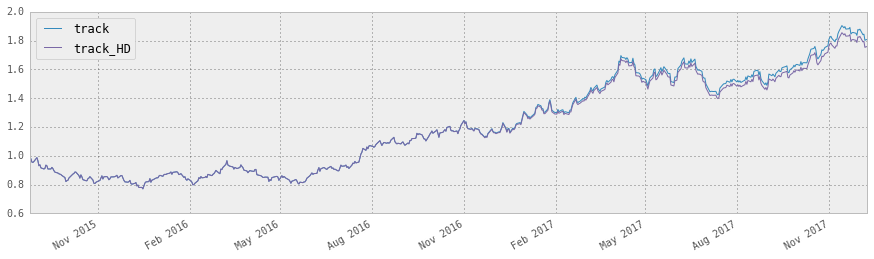

In [16]:
harddiv = 0.035
k = 300
df['track_HD'] = new_col(df['track'].values, df['day_diff'].values, harddiv, k)
df[['track', 'track_HD']].plot(figsize=(15, 4));
df['track_HD'] = new_col_C(df['track'].values, df['day_diff'].values, harddiv, k)
df[['track', 'track_HD']].plot(figsize=(15, 4));

In [14]:
%timeit new_col(df['track'].values, df['day_diff'].values, harddiv, k)
%timeit new_col_C(df['track'].values, df['day_diff'].values, harddiv, k)

1000 loops, best of 3: 235 µs per loop
100000 loops, best of 3: 12.6 µs per loop
